# TP3 : Reconnaissance de mots isolés par programmation dynamique (DTW)

NOM - PRÉNOM :
Déposer le notebook sur moodle à la fin de la séance.

In [8]:
import numpy as np
from math import floor, inf, dist
import scipy.io.wavfile as wav
import os
import matplotlib.pyplot as plt

# Réutilisation de fonctions pour la lecture et la paramétrisation

In [9]:
# Réutiliser la fonction lecture permettant de lire un fichier son et de connaître ses caractéristiques 
# (fréquence d’échantillonnage, durée).

# LECTURE d'un fichier Wave
def lecture(fichier, nb_bits = 16):
    # Lire le fichier son
    fe, son = wav.read(fichier)
    
    # Durée du fichier en secondes
    duree = len(son) / fe
    
    # Normalisation des échantillons entre -1 et 1
    max_val = 2 ** (nb_bits - 1)
    son_normalise = son / max_val
    
    return son_normalise, fe, duree
    

In [10]:
# Réutiliser la fonction parametrisation qui calcule les paramètres acoustiques
# (coefficients cepstraux) d’un fichier sonore sur des fenêtres de taille  "taille_fenetre"   avec un
# recouvrement de moitié .
    
# Calcul de "nbe_coef" coefficients cepstraux
def parametrisation(signal, taille_fenetre, nbe_coef):
    # Initialisation de la matrice résultat
    recouvrement = floor(taille_fenetre / 2)
    nb_fen = floor((np.size(signal) - taille_fenetre) / recouvrement) + 1
    mfcc = np.zeros((nb_fen, nbe_coef))

    # Calcul des MFCC
    for fen in range(nb_fen):
        p = fen * recouvrement
        spectre = abs(np.fft.fft(np.multiply(signal[p:p + taille_fenetre], np.hamming(taille_fenetre))))
        cepstre = np.fft.fft(np.log(spectre))
        cc = cepstre[1:nbe_coef+1].real
        mfcc[fen, :] = cc

    return mfcc
    

In [11]:
# Modifier votre fonction   parametrisation_total  (utilisant la fonction   parametrisation  )
# afin qu’elle permette de calculer les paramètres pour l’ensemble des fichiers d’un répertoire
# rep_wav   et de stocker les résultats dans un répertoire   rep_mfcc. Cette fonction renvoie
# la liste des noms de fichiers traités.
    
# Fonction de paramétrisation totale --> tous les fichiers du répertoire 'WAV/APP'
def parametrisation_total(taille_fenetre, nbe_coef, rep_wav, rep_mfcc, nb_bits = 16):
    # Vérifier si le répertoire de sortie existe, sinon le créer
    if not os.path.exists(rep_mfcc):
        os.makedirs(rep_mfcc)
    
    # Liste des fichiers traités
    fichiers_traitees = []
    
    # Parcourir tous les fichiers du répertoire 'rep_wav'
    for fichier in os.listdir(rep_wav):
        # Vérifier si le fichier est bien un fichier .wav
        if fichier.endswith('.wav'):
            # Lire le fichier audio
            fe, signal = wav.read(os.path.join(rep_wav, fichier))
            
            # Appeler la fonction parametrisation pour obtenir les coefficients cepstraux
            mfcc = parametrisation(signal, taille_fenetre, nbe_coef)
            
            # Enregistrer les MFCC dans un fichier .mfcc
            nom_fichier_mfcc = os.path.join(rep_mfcc, fichier.replace('.wav', '.mfcc'))
            np.savetxt(nom_fichier_mfcc, mfcc,fmt='%f')
            
            # Ajouter le nom du fichier traité à la liste
            fichiers_traitees.append(fichier)
    
    # Retourner la liste des fichiers traités
    return fichiers_traitees


# Programmation dynamique

In [12]:
# Ecrire une fonction dtw qui prend deux arguments en entrée : la matrice de coefficients
# cepstraux du signal à reconnaître (observation) et la matrice de coefficients cepstraux d'un
# signal de référence. Cette fonction renvoie le coût normalisé.
    
# Calcul de la DTW entre deux vecteurs
def dtw(mfcc_ref, mfcc_obs):
    # Taille des matrices de coefficients cepstraux
    n, m = mfcc_ref.shape
    p, q = mfcc_obs.shape
    
    # Création de la matrice de coût initialisée à l'infini
    dtw_matrix = np.inf * np.ones((n + 1, m + 1))
    
    # Initialisation du point de départ (coin supérieur gauche)
    dtw_matrix[0, 0] = 0
    
    # Calcul du coût DTW en remplissant la matrice
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Calcul de la distance entre les deux coefficients (on utilise ici la distance Euclidienne)
            dist = np.linalg.norm(mfcc_ref[i - 1] - mfcc_obs[j - 1])
            
            # Remplir la matrice de coût avec le minimum entre les voisins
            dtw_matrix[i, j] = dist + min(dtw_matrix[i - 1, j],    # De haut
                                          dtw_matrix[i, j - 1],    # De gauche
                                          dtw_matrix[i - 1, j - 1]) # Diagonale
    
    # Le coût total est dans le coin inférieur droit
    dtw_cost = dtw_matrix[n, m]
    
    # Normalisation du coût : on divise par la longueur des signaux
    normalized_cost = dtw_cost / max(n, m)
    
    return normalized_cost



In [13]:
#Ecrire une fonction   dtw_total   (utilisant la fonction   dtw  ) qui calcule la DTW sur toutes
# les observations (fichiers Wave) du répertoire   rep_obs   par rapport   toutes les références
# (fichiers MFCC) du répertoire   rep_ref. Cette fonction renvoie une matrice de coûts de taille
# nb_fichier_obs x nb_fichier_ref.

# DTW sur toutes les observations par rapport à toutes les références

def DTW_total(taille_fenetre, nbe_coef, rep_mfcc_ref, rep_wav_obs, nb_bits=16):
    # Récupérer la liste des fichiers de référence (MFCC) et des fichiers d'observation (Wav)
    fichiers_ref = [f for f in os.listdir(rep_mfcc_ref) if f.endswith('.mfcc')] 
    fichiers_obs = [f for f in os.listdir(rep_wav_obs) if f.endswith('.wav')]
    
    # Nombre de fichiers de référence et d'observations
    nb_fichier_ref = len(fichiers_ref)
    nb_fichier_obs = len(fichiers_obs)
    
    # Initialisation de la matrice des coûts
    couts_dtw = np.zeros((nb_fichier_obs, nb_fichier_ref))
    
    # Parcourir les fichiers d'observation
    for i, fichier_obs in enumerate(fichiers_obs):
        # Lire l'observation et calculer les MFCC
        fe, signal = wav.read(os.path.join(rep_wav_obs, fichier_obs))
        mfcc_obs = parametrisation(signal, taille_fenetre, nbe_coef)
        
        # Parcourir les fichiers de référence
        for j, fichier_ref in enumerate(fichiers_ref):
            # Charger la référence (MFCC) en tant que fichier texte
            mfcc_ref = np.loadtxt(os.path.join(rep_mfcc_ref, fichier_ref))  # Lecture d'un fichier texte
            
            # Calculer la DTW pour cette paire observation-référence
            couts_dtw[i, j] = dtw(mfcc_ref, mfcc_obs)
    
    return couts_dtw




# Affichages et tests

In [14]:
# Ecrire un programme principal qui lance les fonctions précédentes et affiche pour chaque
# observation (mot inconnu), le mot le plus probable.

# Initialisation
q = 16
taille_fenetre = 1024
nbe_coef = 16
rep_ref = 'SIGNAL/REF'
rep_obs = 'SIGNAL/OBS'
rep_mfcc = 'MFCC'


In [15]:
# Paramétrisation des fichiers références

# Test de la DTW

signal_ref, fe_ref, duree_ref = lecture(rep_ref+'/alpha.wav', 16)
print(signal_ref)
mfcc_ref = parametrisation(signal_ref, 1024, 8)

signal_obs, fe_obs, duree_obs = lecture(rep_obs+'/alpha.wav', 16)
print(signal_obs)
mfcc_obs = parametrisation(signal_obs, 1024, 8)

normalized_cost = dtw(mfcc_ref, mfcc_obs)

print (normalized_cost)

[-0.00012207 -0.00045776 -0.00064087 ...  0.00088501  0.00082397
  0.00085449]
[ 3.05175781e-05 -2.13623047e-04 -6.10351562e-04 ... -1.67846680e-03
 -2.34985352e-03 -2.04467773e-03]
497.9252119904691


In [16]:
# DTW sur toutes les observations par rapport à chaque référence
taille_fenetre = 1024
nbe_coef = 8

parametrisation_total(taille_fenetre, nbe_coef, rep_ref, rep_mfcc)


all_costs = DTW_total(taille_fenetre, nbe_coef, rep_mfcc, rep_obs)

print(f"All costs = {all_costs}")

All costs = [[405.01140389 483.68412485 463.38834831 580.38236834 453.69446481
  513.86533075 523.45492806 637.65702817 549.93260926 544.67771274
  480.59804219 457.01402976 549.91525008]
 [336.17239011 423.36197075 434.59598583 530.13876408 480.85371716
  442.55963157 483.74878766 695.81712374 521.73364607 474.04649138
  422.4570465  489.24412309 519.96623601]
 [569.60449335 496.53903331 574.61508214 615.64066382 732.7776434
  547.48938186 468.46681754 646.77031807 537.81394742 555.18137478
  621.83515261 682.29734338 525.8650698 ]
 [344.08383521 429.71554185 455.44185428 551.34755232 465.226365
  471.20009983 535.45148296 721.8124007  533.59283002 488.3444554
  430.70069625 533.02603512 521.83651138]
 [449.81513714 489.37088175 504.24703051 579.27178813 503.83939677
  562.24184171 575.22486263 649.16075872 534.3837878  498.44135317
  429.13061731 496.94468546 543.06627197]
 [278.751039   287.99281059 408.80210395 396.11498852 336.39691253
  411.76915612 404.98249052 550.8367167  389.

Références :
['india.mfcc', 'golf.mfcc', 'lima.mfcc', 'mike.mfcc', 'hotel.mfcc', 'juliett.mfcc', 'kilo.mfcc', 'charlie.mfcc', 'alpha.mfcc', 'delta.mfcc', 'bravo.mfcc', 'echo.mfcc', 'foxtrott.mfcc']


Observations :
['echo.wav', 'india.wav', 'kilo.wav', 'delta.wav', 'foxtrott.wav', 'hotel.wav', 'lima.wav', 'alpha.wav', 'mike.wav', 'charlie.wav', 'golf.wav', 'juliett.wav', 'bravo.wav']


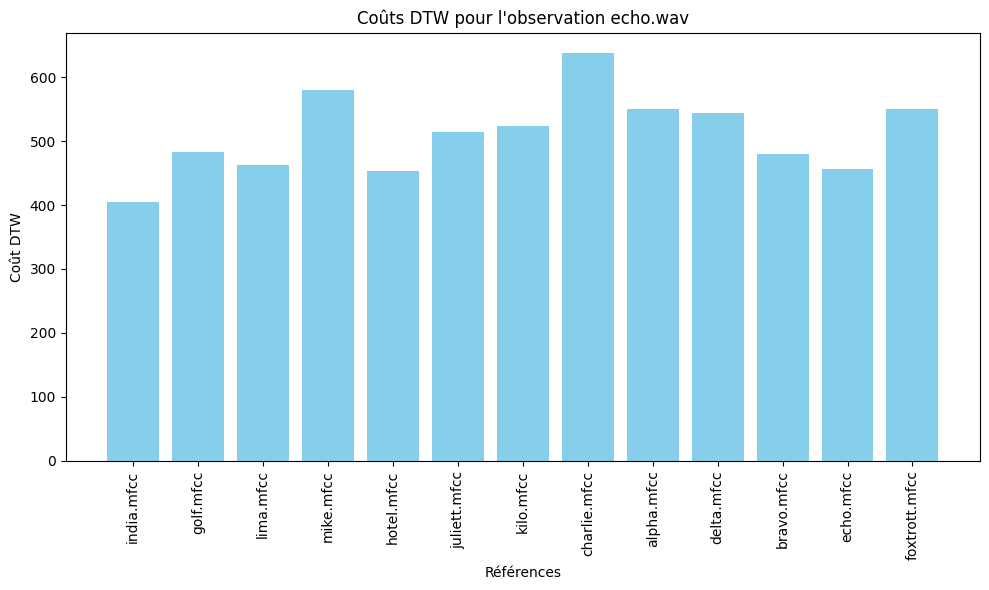

Le mot le plus probable pour l'observation echo.wav est : india.mfcc avec un coût DTW de 405.0114


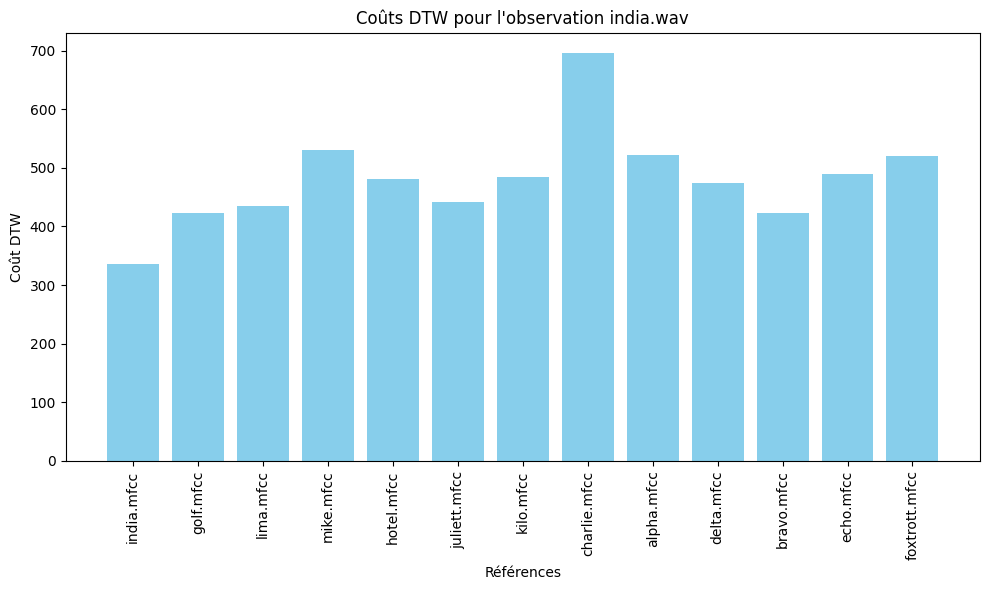

Le mot le plus probable pour l'observation india.wav est : india.mfcc avec un coût DTW de 336.1724


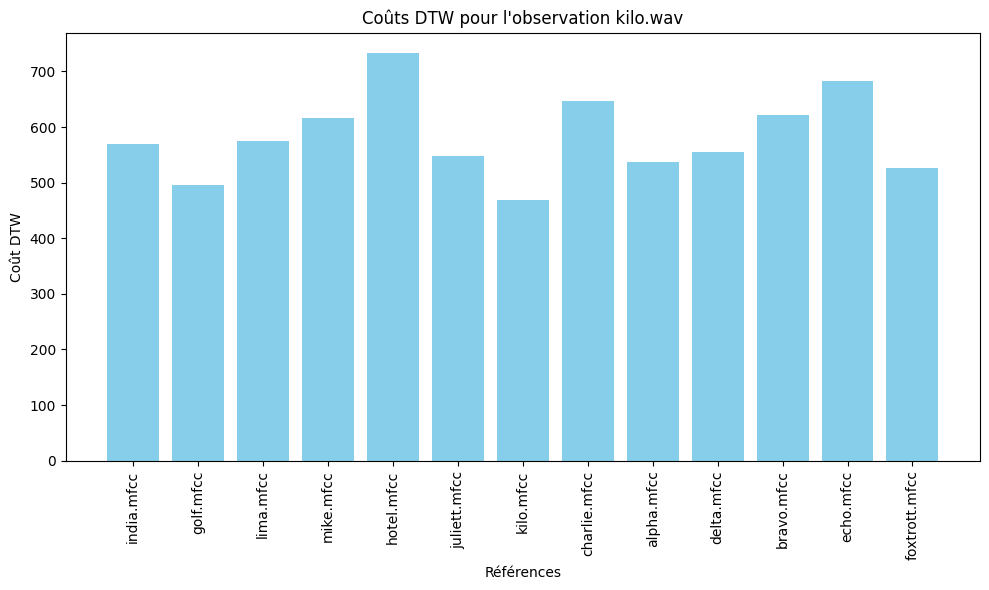

Le mot le plus probable pour l'observation kilo.wav est : kilo.mfcc avec un coût DTW de 468.4668


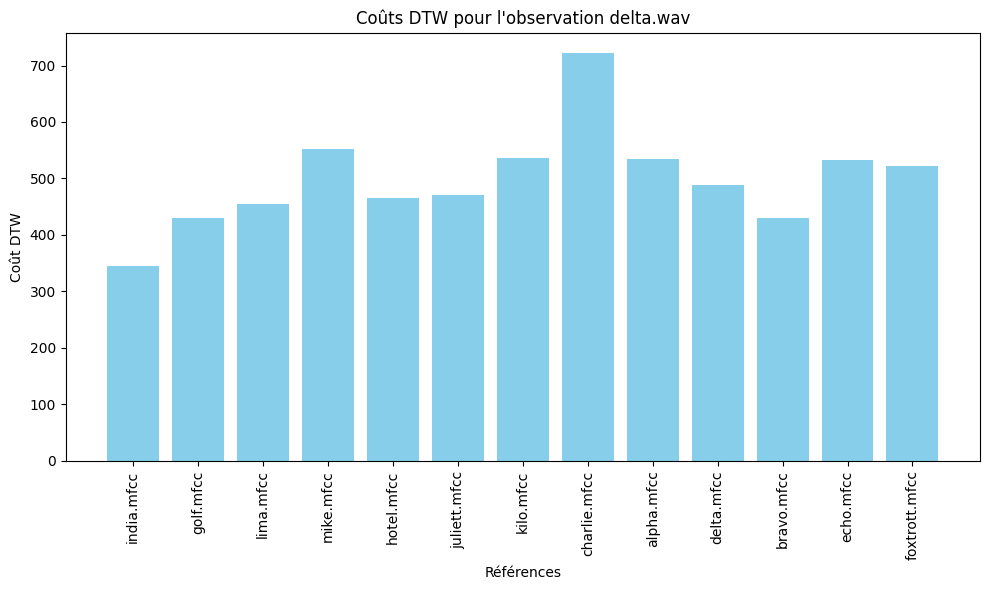

Le mot le plus probable pour l'observation delta.wav est : india.mfcc avec un coût DTW de 344.0838


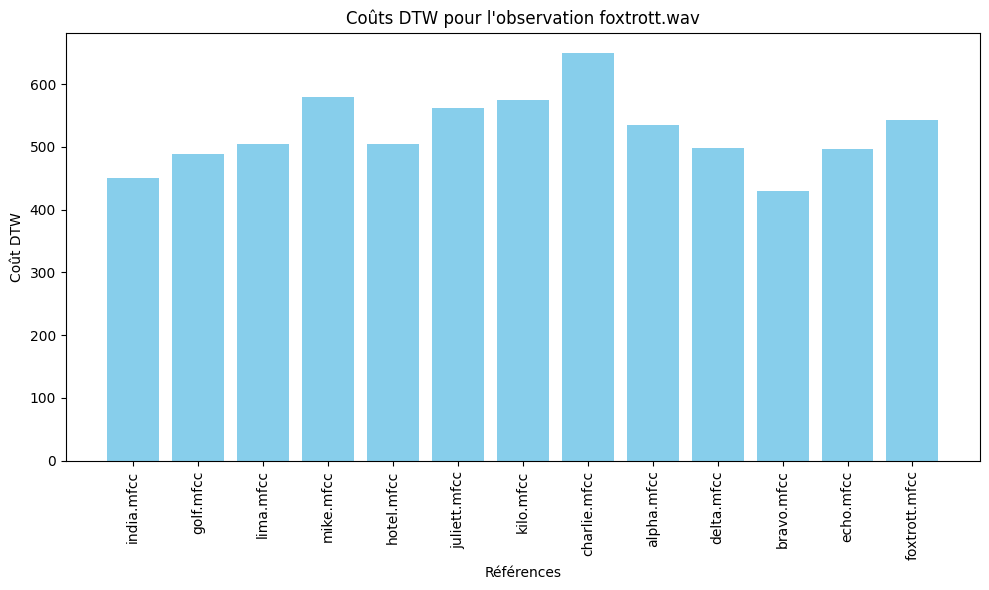

Le mot le plus probable pour l'observation foxtrott.wav est : bravo.mfcc avec un coût DTW de 429.1306


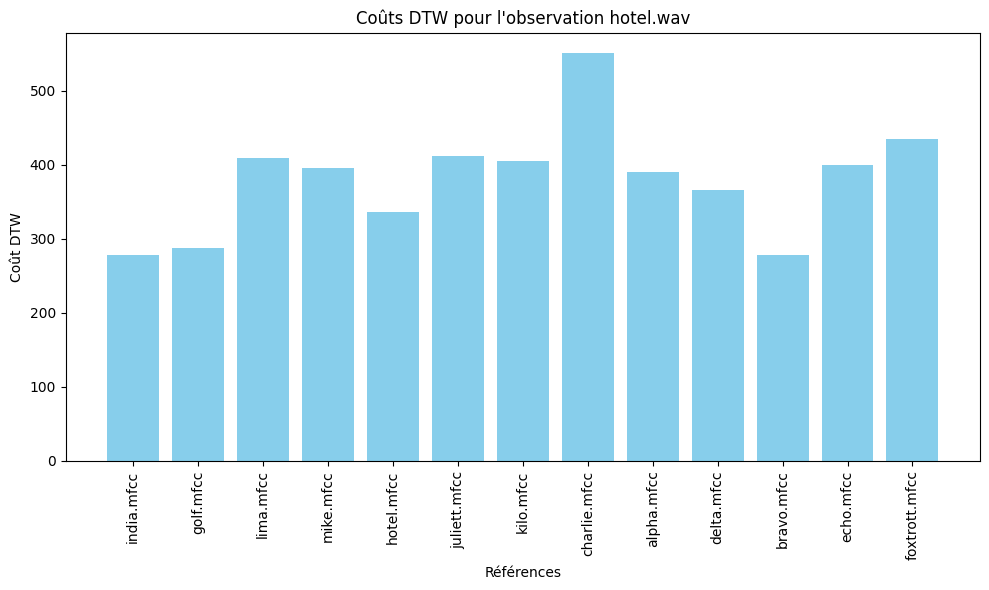

Le mot le plus probable pour l'observation hotel.wav est : bravo.mfcc avec un coût DTW de 278.1764


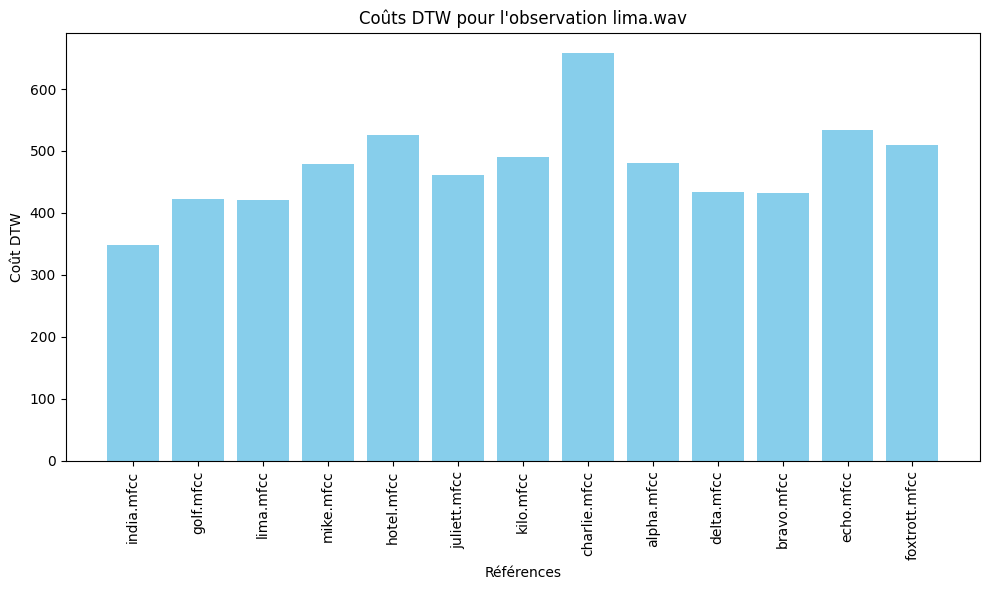

Le mot le plus probable pour l'observation lima.wav est : india.mfcc avec un coût DTW de 347.6519


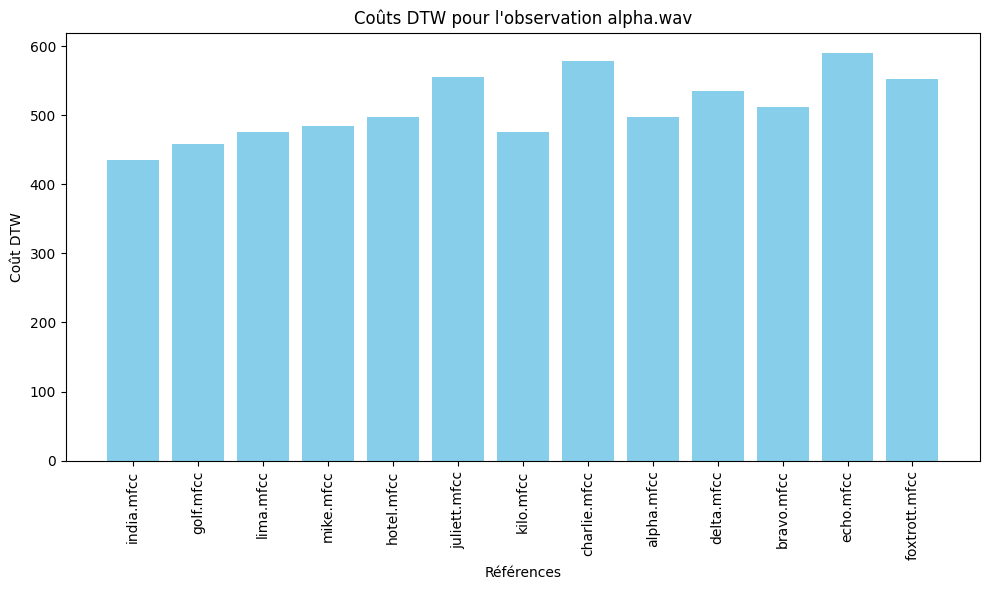

Le mot le plus probable pour l'observation alpha.wav est : india.mfcc avec un coût DTW de 434.9937


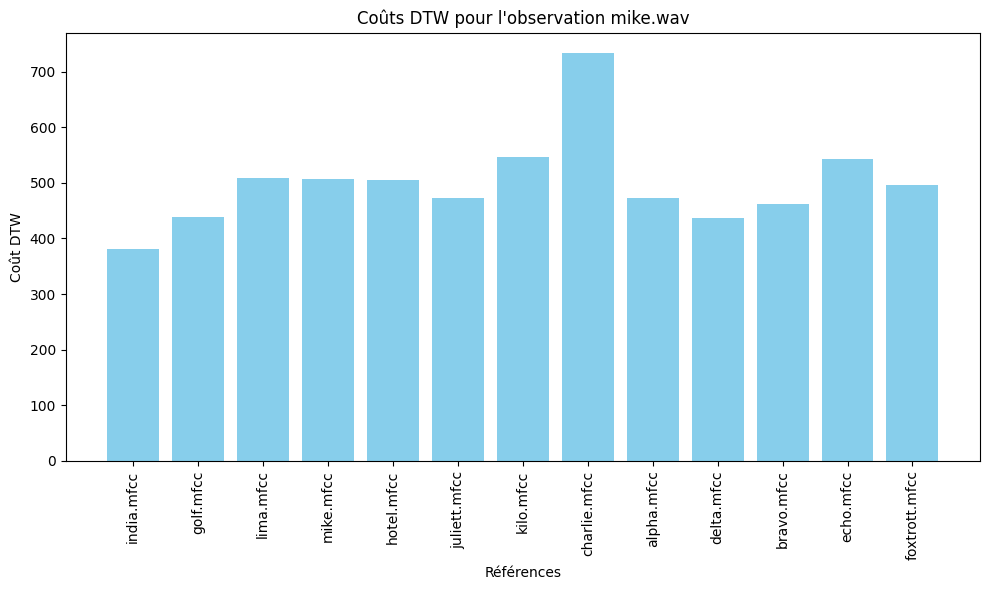

Le mot le plus probable pour l'observation mike.wav est : india.mfcc avec un coût DTW de 380.9935


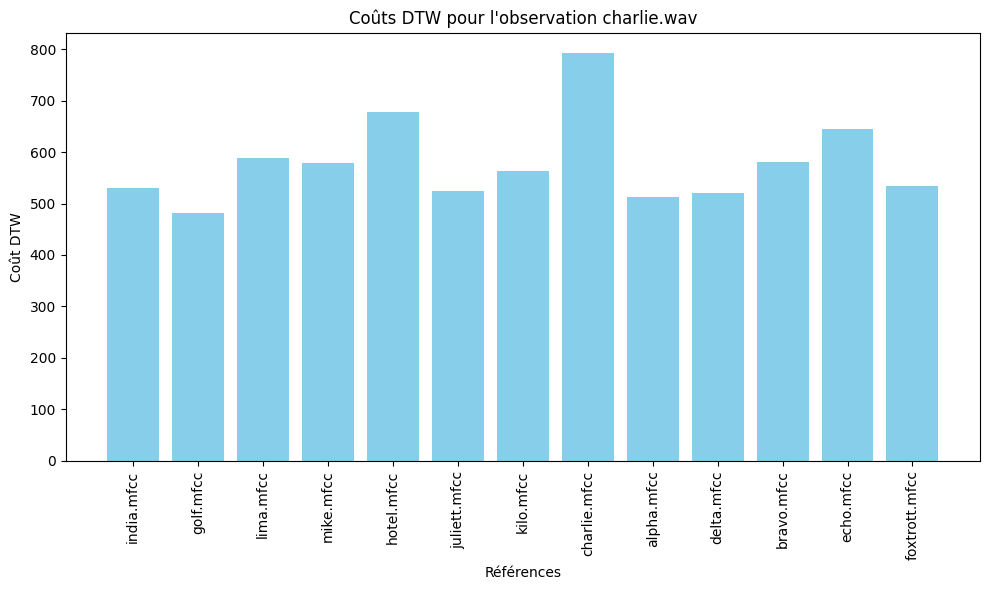

Le mot le plus probable pour l'observation charlie.wav est : golf.mfcc avec un coût DTW de 481.5495


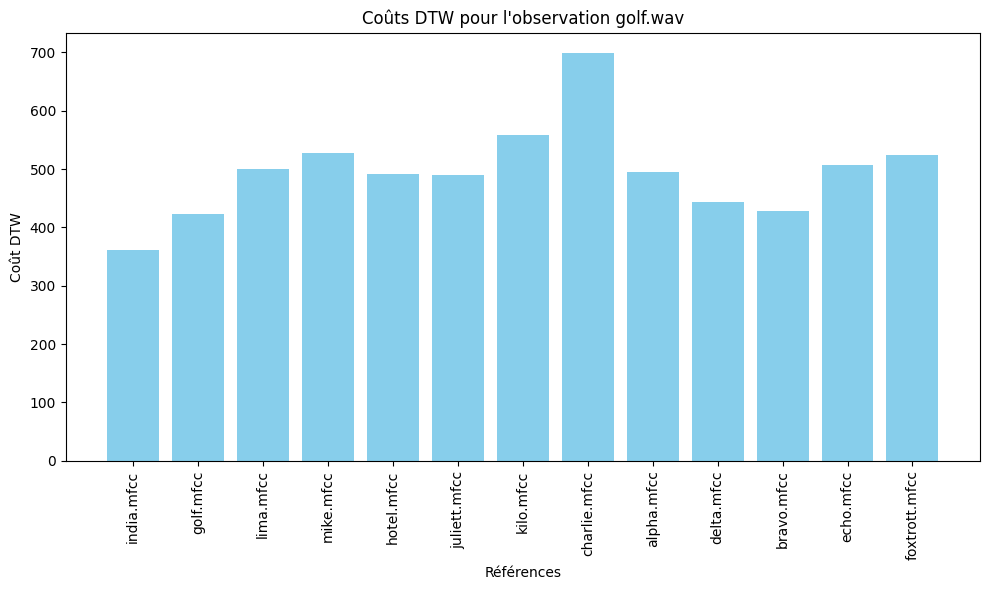

Le mot le plus probable pour l'observation golf.wav est : india.mfcc avec un coût DTW de 361.0244


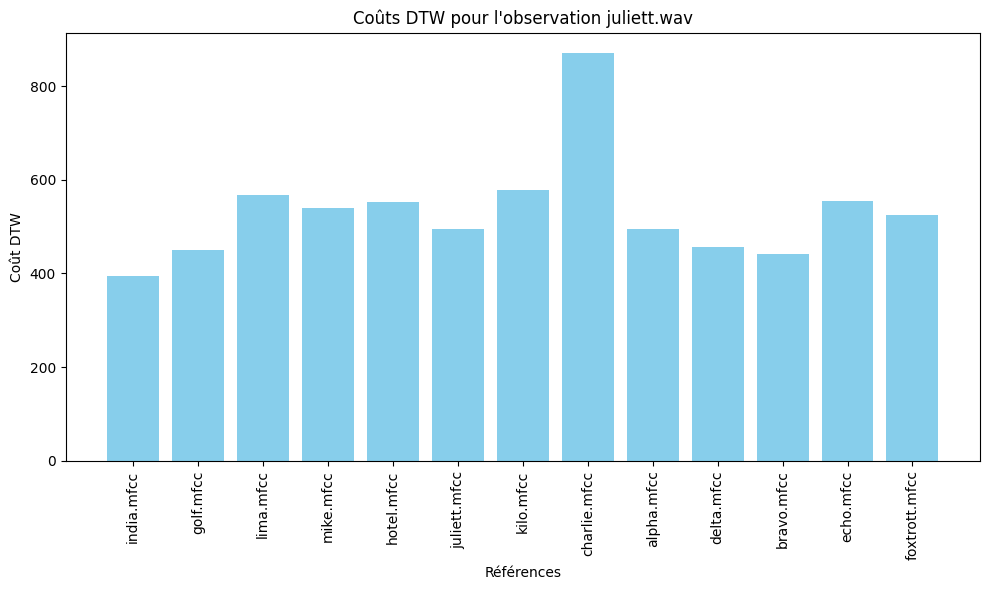

Le mot le plus probable pour l'observation juliett.wav est : india.mfcc avec un coût DTW de 393.6555


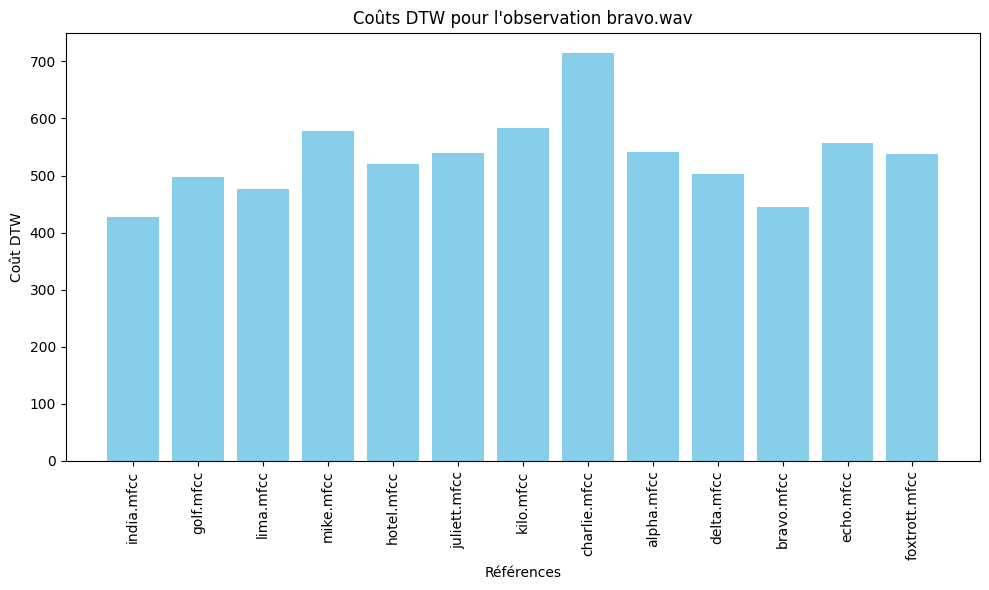

Le mot le plus probable pour l'observation bravo.wav est : india.mfcc avec un coût DTW de 426.6630

Score final de reconnaissance (moyenne des coûts DTW) : 508.1230


In [17]:

# Affichage amélioré

# Ajouter à votre programme principal, un affichage des coûts entre une observation et chaque
# référence sous forme d'histogramme via la commande bar.
# Calculer le score de reconnaissance.

# Pour chaque observation, affichage des coûts (par rapport aux références) sous forme d'histogramme

# Récupérer les noms des fichiers de référence et d'observation
fichiers_ref = [f for f in os.listdir(rep_mfcc) if f.endswith('.mfcc')]  # Fichiers de référence .mfcc

fichiers_obs = [f for f in os.listdir(rep_obs) if f.endswith('.wav')]  # Fichiers d'observation .wav


print("Références :")
print(fichiers_ref)  # Affiche les fichiers de référence
print("\n")

print("Observations :")
print(fichiers_obs)  # Affiche les fichiers d'observation


# Affichage des coûts DTW sous forme d'histogramme
for i, fichier_obs in enumerate(fichiers_obs):
    if fichier_obs.endswith('.wav'):
        # Affichage des coûts pour chaque observation sous forme d'histogramme
        plt.figure(figsize=(10, 6))
        plt.bar(range(all_costs.shape[1]), all_costs[i], color='skyblue')
        plt.xlabel('Références')
        plt.ylabel('Coût DTW')
        plt.title(f"Coûts DTW pour l'observation {fichier_obs}")
        plt.xticks(range(all_costs.shape[1]), fichiers_ref, rotation=90)
        plt.tight_layout()  # Pour éviter que les labels se superposent
        plt.show()

        # Calcul du mot le plus probable (référence avec le coût minimal)
        index_min = np.argmin(all_costs[i])  # Trouver l'index du coût minimal
        print(f"Le mot le plus probable pour l'observation {fichier_obs} est : {fichiers_ref[index_min]} avec un coût DTW de {all_costs[i, index_min]:.4f}")

# Calcul du score de reconnaissance (moyenne des coûts DTW)
mean_dtw = np.mean(all_costs)
print(f"\nScore final de reconnaissance (moyenne des coûts DTW) : {mean_dtw:.4f}")



In [18]:
# Affichage score final


In [19]:
# Autres tests 
# Bien évidemment, afin d’améliorer les résultats, vous pourrez modifier :
# - le nombre de paramètres (coefficients cepstraux) : nbe_coef,
# - la taille de la fenêtre d’analyse : taille_fenetre,
# ET TESTER AVEC VOS PROPRES ENREGISTREMENTS !